In [40]:
import sys
sys.path.insert(0,'../src/')
from curve import *
from utils import *
from multiply_connected_pipe import MultiplyConnectedPipe
import numpy as np
import pickle
from matplotlib import pyplot as plt
import scipy as sp

In [41]:
with open('./pipes_and_shifts.pickle','rb') as f:
    pipes, shifts = pickle.load(f)

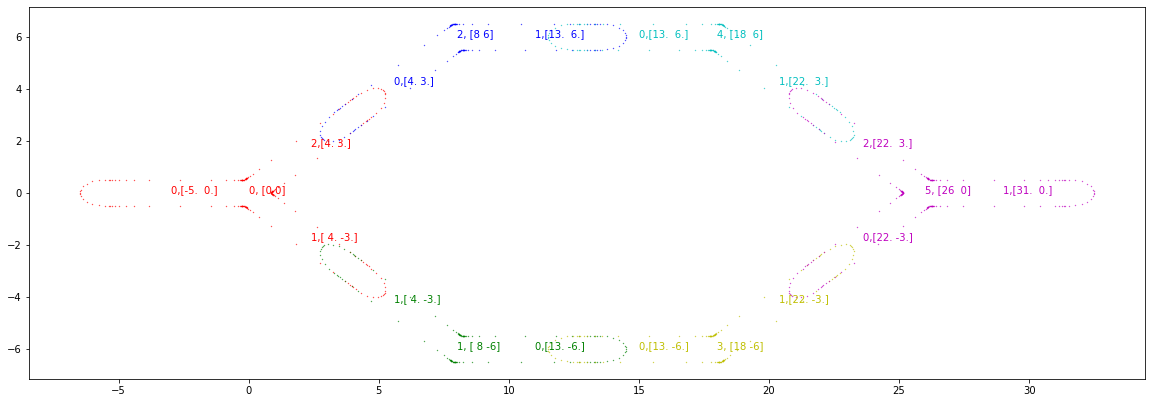

In [42]:
color = ['r','g','b','y','c','m','k']

fig,ax = plt.subplots(figsize=(20,10))
ax.set_aspect('equal')

for a,i,j,c in zip(range(10),pipes,shifts,color):
    panel_break_pts = np.array([cplx2pt(p.start_pt) + j for p in i.panels])
    ax.scatter(panel_break_pts[:,0], panel_break_pts[:,1],c=c,s=0.1)
    for k,let in enumerate(i.lets):
        ax.text(*(0.6*let.matching_pt + j),f'{k},{let.matching_pt + j}',color=c)
    ax.text(*j,f'{a}, {j}',color=c)

In [43]:
pipe = pipes[0]
panels = pipe.panels
pairs = pipe.mat_vec.close_panel_interactions

In [83]:
spares_k1_modify = sp.sparse.lil_matrix((len(pipe.t), len(pipe.t)), dtype=np.complex128)
spares_k1_original = sp.sparse.lil_matrix((len(pipe.t), len(pipe.t)), dtype=np.complex128)
spares_k2_modify = sp.sparse.lil_matrix((len(pipe.t), len(pipe.t)), dtype=np.complex128)
spares_k2_original = sp.sparse.lil_matrix((len(pipe.t), len(pipe.t)), dtype=np.complex128)

In [84]:
pipe.mat_vec.build_k()

In [142]:
for i,(p, targets_index) in enumerate(zip(panels,pairs)):
    
    targets = pipe.t[targets_index]
    
    panel_index_start = i*p.n
    panel_index_end = (i+1)*p.n
    
    k1,k2 = p._build_for_targets(targets)
    
    for i1,i2 in enumerate(targets_index):

        spares_k1_modify[i2,panel_index_start:panel_index_end] = k1[i1]
        spares_k2_modify[i2,panel_index_start:panel_index_end] = k2[i1]

        spares_k1_original[i2,panel_index_start:panel_index_end] = pipe.mat_vec.K1[i2,panel_index_start:panel_index_end]
        spares_k2_original[i2,panel_index_start:panel_index_end] = pipe.mat_vec.K2[i2,panel_index_start:panel_index_end]
    

In [187]:
(np.diagonal(spares_k2_modify.toarray()) - 0.5)

array([ 5.26245714e-14-0.09676954j, -1.66533454e-15-0.03958646j,
       -1.66533454e-15-0.02030612j, ...,  8.43769499e-15+0.02030612j,
       -1.66533454e-15+0.03958646j,  1.64313008e-14+0.09676954j])

In [189]:
(np.diagonal(spares_k2_original.toarray()))

array([ 0.00000000e+00+0.00000000e+000j,  0.00000000e+00+0.00000000e+000j,
       -4.08736058e-67-1.90447013e-134j, ...,
        0.00000000e+00+0.00000000e+000j,  0.00000000e+00+0.00000000e+000j,
        0.00000000e+00+0.00000000e+000j])

In [180]:
k1_modified = (pipe.mat_vec.K1 +  spares_k1_modify - spares_k1_original)
k2_modified = (pipe.mat_vec.K2 +  spares_k2_modify - spares_k2_original)

In [181]:
np.linalg.cond(k1_modified - np.eye(len(pipe.t)))

4.201685855049758e+18

这个 K2 项不对啊

In [182]:
np.linalg.cond(pipe.mat_vec.K1)

1.1321012702444927e+20

In [174]:
k2_modified[0]

matrix([[ 5.00000000e-01-0.09676954j, -1.63386266e+00+0.31621626j,
          2.82480385e+00-0.54670991j, ..., -2.60098694e-13+1.26664139j,
          1.56059216e-13-0.73262364j, -9.95160220e-14+0.22419988j]])

In [175]:
pipe.mat_vec.K2[0]

array([ 0.00000000e+00-0.00000000e+00j,  0.00000000e+00-3.53394965e-17j,
       -5.44720440e-69+1.76697482e-17j, ...,
       -1.18956679e-15+1.76697482e-17j, -4.13088939e-15-0.00000000e+00j,
       -2.78792169e-14-3.53394965e-17j])

In [173]:
np.linalg.norm(k2_modified - pipe.mat_vec.K2)

182.6877780403728